# kettler analysis

## intro code

In [3]:
import os
import sys
import pandas as pd
from pathlib import Path
from textwrap import wrap
import plotly.express as px
import datetime as dt
from pandas_plots import tbl, pls, hlp
from importlib.metadata import version

print(f"pandas-plots: {version("pandas-plots")}")
# * get src directory which *must* be parent
dir_src = Path(os.getcwd()).parent.parent

# # * add to path
# if dir_src.as_posix() not in sys.path:
#     sys.path.append(dir_src.as_posix())

# * display / style settings
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 160
pd.options.display.precision = 2
pd.options.mode.chained_assignment = None

# * theme settings
os.environ["THEME"] = "light"

DIR_IMAGES = Path("../../img/analysis/")

print(f"last run: {dt.datetime.now()}")

pandas-plots: 0.11.27
last run: 2025-01-07 23:44:55.086445


## load data

In [4]:
df_training=pd.read_parquet('data/trainings.pq')
df_records=pd.read_parquet('data/records.pq')

## analysis

In [5]:
tbl.describe_df(df_training.iloc[:,1:], 'training', use_columns=False, use_plot=False)

🔵 *** df: training ***
🟣 shape: (1_180, 13) columns: ['Device' 'Calibration' 'Software' 'Date' 'Time' 'RecordIntervall'
 'Transmission' 'Energy' 'TrainingDateTime' 'FileName' 'CreatedAt'
 'Duration_minutes' 'Streak_days'] 
🟣 duplicates: 0
🟣 uniques: [{Device: 1 Calibration: 1 Software: 1 Date: 1_176 Time: 1_158 RecordIntervall: 1 Transmission: 
1 Energy: 1 TrainingDateTime: 1_179 FileName: 1_180 CreatedAt: 47 Duration_minutes: 
115 Streak_days: 14}]
🟣 missings: [{Device: 0 Calibration: 0 Software: 0 Date: 0 Time: 0 RecordIntervall: 0 Transmission: 
0 Energy: 0 TrainingDateTime: 0 FileName: 0 CreatedAt: 0 Duration_minutes: 0 Streak_days: 
0}]
--- column stats (numeric)
🟠 Duration_minutes(115|float64) min: 0.667 | lower: 29.75 | q25: 30.0 | median: 30.0 | mean: 32.217 | q75: 30.166666666666668 | upper: 30.417 | max: 73.833 | std: 6.453 | cv: 0.2 | sum: 38_015.833 | skew: 2.667 | kurto: 11.712
🟠 Streak_days(14|int64) min: 0 | lower: 0 | q25: 0.0 | median: 1.0 | mean: 1.006 | q75: 1.0 | up

,Device,Calibration,Software,Date,Time,RecordIntervall,Transmission,Energy,TrainingDateTime,FileName,CreatedAt,Duration_minutes,Streak_days
0,SJ10X SKYLON 5,07655-350-2007,3367,11.01.2014,20:09:26,10,9.5,6.0,2014-01-11T20:09:26+01:00,Training 11.01.2014 20h09m26s.xml,2021-01-07 23:58:46.053121,53.17,0
1,SJ10X SKYLON 5,07655-350-2007,3367,12.01.2014,18:49:44,10,9.5,6.0,2014-01-12T18:49:44+01:00,Training 12.01.2014 18h49m44s.xml,2021-01-07 23:58:46.053121,56.67,0
2,SJ10X SKYLON 5,07655-350-2007,3367,13.01.2014,21:56:13,10,9.5,6.0,2014-01-13T21:56:13+01:00,Training 13.01.2014 21h56m13s.xml,2021-01-07 23:58:46.053121,59.17,0


🔵 *** df: records ***
🟣 shape: (228_095, 7) columns: ['Pulse' 'Power' 'RPM' 'TimePassed_minutes' 'TimePassed_percent'
 'Score_10sec' 'TrainingId'] 
🟣 duplicates: 0
🟣 uniques: [{Pulse: 182 Power: 52 RPM: 61 TimePassed_minutes: 443 TimePassed_percent: 23_416 
Score_10sec: 1_033 TrainingId: 1_180}]
🟣 missings: [{Pulse: 0 Power: 0 RPM: 0 TimePassed_minutes: 0 TimePassed_percent: 0 Score_10sec: 
0 TrainingId: 0}]
--- column stats (numeric)
🟠 Pulse(182|int64) min: 0 | lower: 0 | q25: 0.0 | median: 93.0 | mean: 68.853 | q75: 127.0 | upper: 220 | max: 220 | std: 65.539 | cv: 0.952 | sum: 15_705_123 | skew: 0.049 | kurto: -1.7
🟠 Power(52|int64) min: 25 | lower: 87.5 | q25: 140.0 | median: 165.0 | mean: 160.756 | q75: 175.0 | upper: 227.5 | max: 300 | std: 22.972 | cv: 0.143 | sum: 36_667_600 | skew: -0.713 | kurto: 2.506
🟠 RPM(61|int64) min: 14 | lower: 46.0 | q25: 52.0 | median: 54.0 | mean: 53.64 | q75: 56.0 | upper: 62.0 | max: 89 | std: 3.513 | cv: 0.065 | sum: 12_234_916 | skew: -0.864 | k

,Pulse,Power,RPM,TimePassed_minutes,TimePassed_percent,Score_10sec,TrainingId
0,0,50,46,0.17,3.13e-03,1.97e-03,1
1,0,150,45,36.17,6.80e-01,5.77e-03,1
2,0,150,49,36.00,6.77e-01,6.28e-03,1


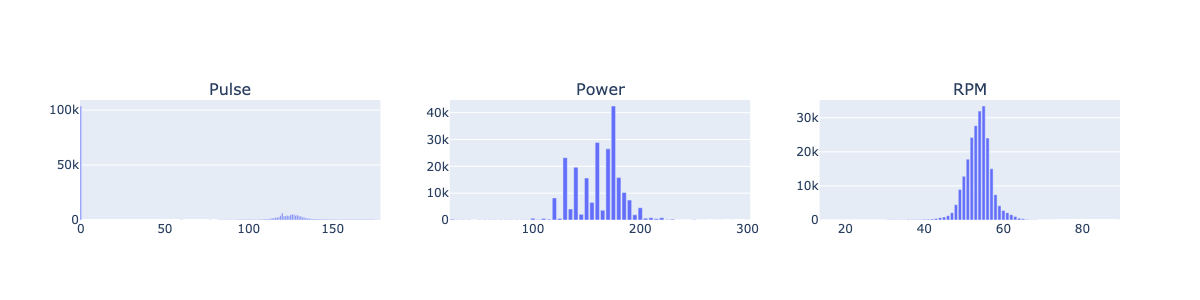

In [6]:
tbl.describe_df(df_records.iloc[:,1:], 'records', use_columns=False, fig_offset=-4)

## enhance tables

In [7]:
#
# * tailor and join both tables

# * id col is new index
if "Id" in df_training.columns:
    df_training.set_index("Id", inplace=True, drop=True)
if "Id" in df_records.columns:
    df_records.set_index("Id", inplace=True, drop=True)

# * convert to proper datetime (remove 'T')
df_training.TrainingDateTime = pd.to_datetime(
    df_training.TrainingDateTime, errors="coerce"
)

# * add daytime (3 cats: morning, day, evening)
df_training["daytime"] = df_training.TrainingDateTime.dt.hour.map(
    lambda x: "morning" if x < 13 else "day" if x < 18 else "evening"
)

# * add day_of_week
df_training["day_of_week"] = df_training.TrainingDateTime.dt.strftime("%A")

# * add date
df_training["training_date"] = df_training.TrainingDateTime.dt.date.astype("datetime64[ns]")

# * join both tables on records level
df = df_records.join(df_training, on="TrainingId")

# * drop unneeded columns: filename, createdat, TrainingId
cols_drop = [col for col in df if len(df[col].unique()) == 1]
print(f"remove these one-item columns:{cols_drop}")

cols_drop += ["Date", "Time", "FileName", "CreatedAt", "TrainingId"]

df.drop(
    # * subtract columns to make the statement idempotent
    columns=set(df.columns) & set(cols_drop),
    inplace=True,
)
df[:3]

remove these one-item columns:['Device', 'Calibration', 'Software', 'RecordIntervall', 'Transmission', 'Energy']


,Pulse,Power,RPM,TimePassed_minutes,TimePassed_percent,Score_10sec,TrainingDateTime,Duration_minutes,Streak_days,daytime,day_of_week,training_date
Id,,,,,,,,,,,,
1,0,50,46,0.17,3.13e-03,1.97e-03,2014-01-11 20:09:26+01:00,53.17,0,evening,Saturday,2014-01-11
2,0,150,45,36.17,6.80e-01,5.77e-03,2014-01-11 20:09:26+01:00,53.17,0,evening,Saturday,2014-01-11
3,0,150,49,36.00,6.77e-01,6.28e-03,2014-01-11 20:09:26+01:00,53.17,0,evening,Saturday,2014-01-11


## duration

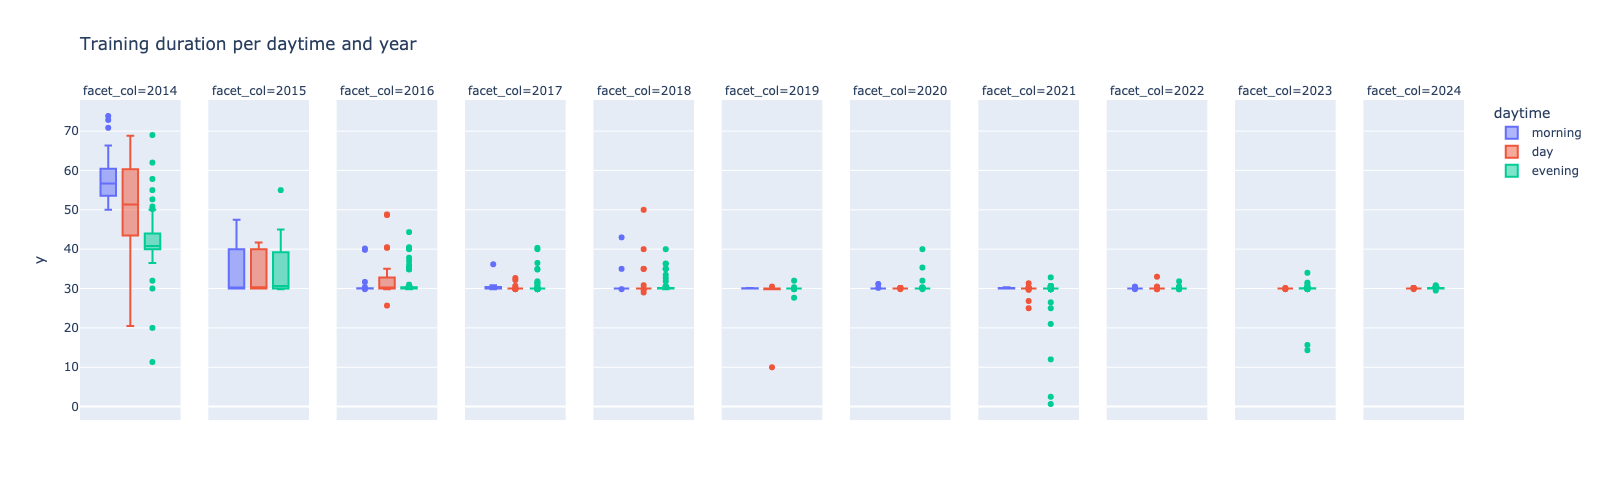

In [8]:
_df = df_training.copy()
# * add aux cols for sorting
_df['_daytime'] = pd.Categorical(_df.daytime, ["morning", "day", "evening"])
_df['_year'] = _df.TrainingDateTime.dt.year

_fig = px.box(
    _df.sort_values(by=["_year","_daytime"]),
    y=_df.Duration_minutes,
    # template=THEME_PLOTLY,
    color='daytime',
    points="outliers",
    # points=False,
    facet_col=_df.TrainingDateTime.dt.year,
    # height=300,
    width=1600,
    title="Training duration per daytime and year",
    )
_fig.show('png')

## streaks

In [9]:
#
# * copy table, must be sorted by TrainingDateTime
_df = (
    df_training.sort_values("TrainingDateTime")
    .reset_index()
    [["Id", "training_date"]]
    .copy()
)

# * add bool for "is a sequence", check if delta to previous training is 1
_df['sequence'] = (_df['training_date'] - _df.shift(1)['training_date']).dt.days.astype('Int16').fillna(1) == 1
# _df['no_interruption_days'] = (_df['training_date'] - _df['training_date'].shift(1)).dt.days.fillna(1).ne(1).cumsum()

# * add section number. cumsum increases on a certain condition (when sequence is False, streak has ended)
_df['section'] = (~_df.sequence).cumsum()

# * fix edge case: very first section has no predessesor and belongs to first streak
_df.loc[1, 'section'] = 0

display(_df[:3])

# * calculate streak
df_training_streak=(_df.groupby(
    'section',
    as_index=False,     # only relevant for series output
    observed=False,     # speeds up processing for large data
    )
    .agg({
        'section':'count',
        'training_date':['min','max'],
        })
    .droplevel(axis=1, level=0)
    .rename(columns={'count':'streak_days', 'min':'start_date', 'max':'end_date'})
    .sort_values(by='streak_days', ascending=False)
    )
df_training_streak[:3]

,Id,training_date,sequence,section
0,1,2014-01-11,True,0
1,2,2014-01-12,True,0
2,3,2014-01-13,True,0


,streak_days,start_date,end_date
280,23,2018-06-10,2018-07-02
395,19,2020-12-28,2021-01-15
485,19,2022-04-17,2022-05-05


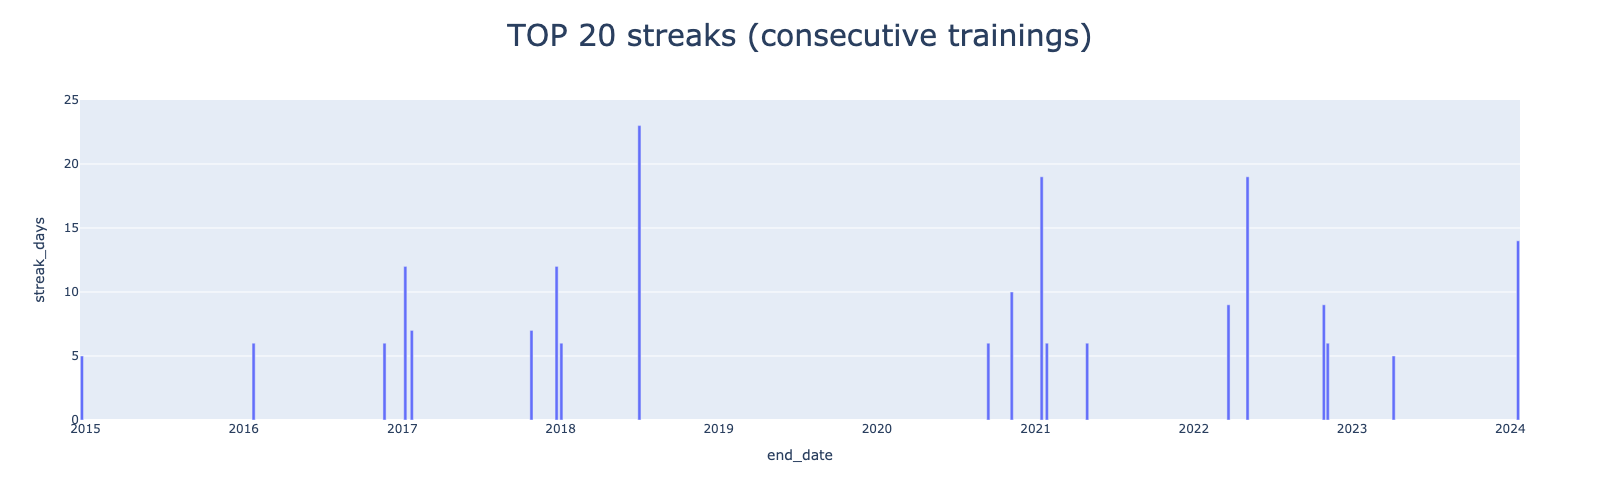

In [10]:
_df = df_training_streak.copy()[:20]
_fig = px.bar(
    _df,
    y="streak_days",
    x=_df['end_date'].astype(str),
    # text='streak_days',
    width=1600,
    labels={"x": "end_date"},
    title="TOP 20 streaks (consecutive trainings)",

)
_fig.update_layout(
    title={
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 30, }
    },
    yaxis_range=[0, 25],
)
_fig.show('png')
_fig.write_image(DIR_IMAGES / 'top20streaks.png')


## aggregations

In [11]:
df=(df_training
    .merge(
        df_records,
        left_on='Id',
        right_on='TrainingId',
    )
)
df['year']=df['TrainingDateTime'].dt.year
# df['YYYY-MM']=df['TrainingDateTime'].dt.strftime('%Y-%m')
# df['month']=df['TrainingDateTime'].dt.month

In [12]:
_df=df.pivot_table(index=df["year"], columns=df["TrainingDateTime"].dt.month, values="Score_10sec", aggfunc="sum")#.fillna(0)
tbl.show_num_df(_df,total_axis='xy', data_bar_axis='xy', kpi_mode="max_min_x",)

TrainingDateTime,1,2,3,4,5,6,7,8,9,10,11,12,Total
year,,,,,,,,,,,,,
2014,30 ⬜,34 🟩,30 🟩,18 ⬜,15 ⬜,14 ⬜,3 ⬜,5 ⬜,21 ⬜,5 🟥,9 ⬜,14 ⬜,197 ⬜
2015,11 ⬜,15 ⬜,17 ⬜,10 ⬜,5 ⬜,11 ⬜,nan ⬜,nan ⬜,15 ⬜,5 ⬜,13 ⬜,15 ⬜,117 ⬜
2016,23 ⬜,11 ⬜,16 ⬜,12 ⬜,3 🟥,7 ⬜,23 🟩,20 🟩,6 ⬜,6 ⬜,18 ⬜,15 ⬜,160 ⬜
2017,35 ⬜,5 🟥,11 ⬜,15 ⬜,11 ⬜,15 ⬜,18 ⬜,9 ⬜,12 ⬜,13 ⬜,9 ⬜,30 🟩,183 ⬜
2018,19 ⬜,nan ⬜,1 🟥,14 ⬜,16 ⬜,39 🟩,22 ⬜,12 ⬜,22 🟩,27 🟩,9 ⬜,27 ⬜,209 🟩
2019,7 🟥,7 ⬜,19 ⬜,11 ⬜,7 ⬜,nan ⬜,2 ⬜,2 🟥,4 🟥,8 ⬜,nan ⬜,15 ⬜,83 🟥
2020,nan ⬜,nan ⬜,nan ⬜,10 ⬜,18 ⬜,9 ⬜,9 ⬜,5 ⬜,16 ⬜,11 ⬜,18 ⬜,25 ⬜,122 ⬜
2021,39 🟩,18 ⬜,9 ⬜,21 ⬜,20 🟩,nan ⬜,6 ⬜,4 ⬜,13 ⬜,20 ⬜,18 ⬜,23 ⬜,191 ⬜
2022,10 ⬜,9 ⬜,19 ⬜,31 🟩,9 ⬜,nan ⬜,4 ⬜,7 ⬜,11 ⬜,23 ⬜,22 🟩,18 ⬜,162 ⬜


In [13]:
_df=df.groupby(
    "year",
    # as_index=False,
).agg(
    # training_min=("training_date", "min"),
    # training_max=("training_date", "max"),
    training_cnt=("training_date", "nunique"),
    duration_mean=("Duration_minutes", "mean"),
    power_max=("Power", "max"),
)
# _df
tbl.show_num_df(_df,total_mode=False, data_bar_axis='x', kpi_mode="max_min_x")

,training_cnt,duration_mean,power_max
year,,,
2014,119 ⬜,49 🟩,275 ⬜
2015,95 ⬜,35 ⬜,230 ⬜
2016,131 ⬜,32 ⬜,250 ⬜
2017,134 🟩,30 ⬜,250 ⬜
2018,132 ⬜,31 ⬜,300 🟩
2019,53 🟥,30 ⬜,240 ⬜
2020,90 ⬜,30 ⬜,235 ⬜
2021,130 ⬜,30 🟥,230 ⬜
2022,113 ⬜,30 ⬜,200 ⬜


## numerics

In [14]:
df=df_training.iloc[:,[8,11]]
df['year']=df['TrainingDateTime'].dt.year.astype(str)
_df1=df[df['year']<'2022'].iloc[:,[2,1]]
_df2=df.iloc[:,[2,1]]


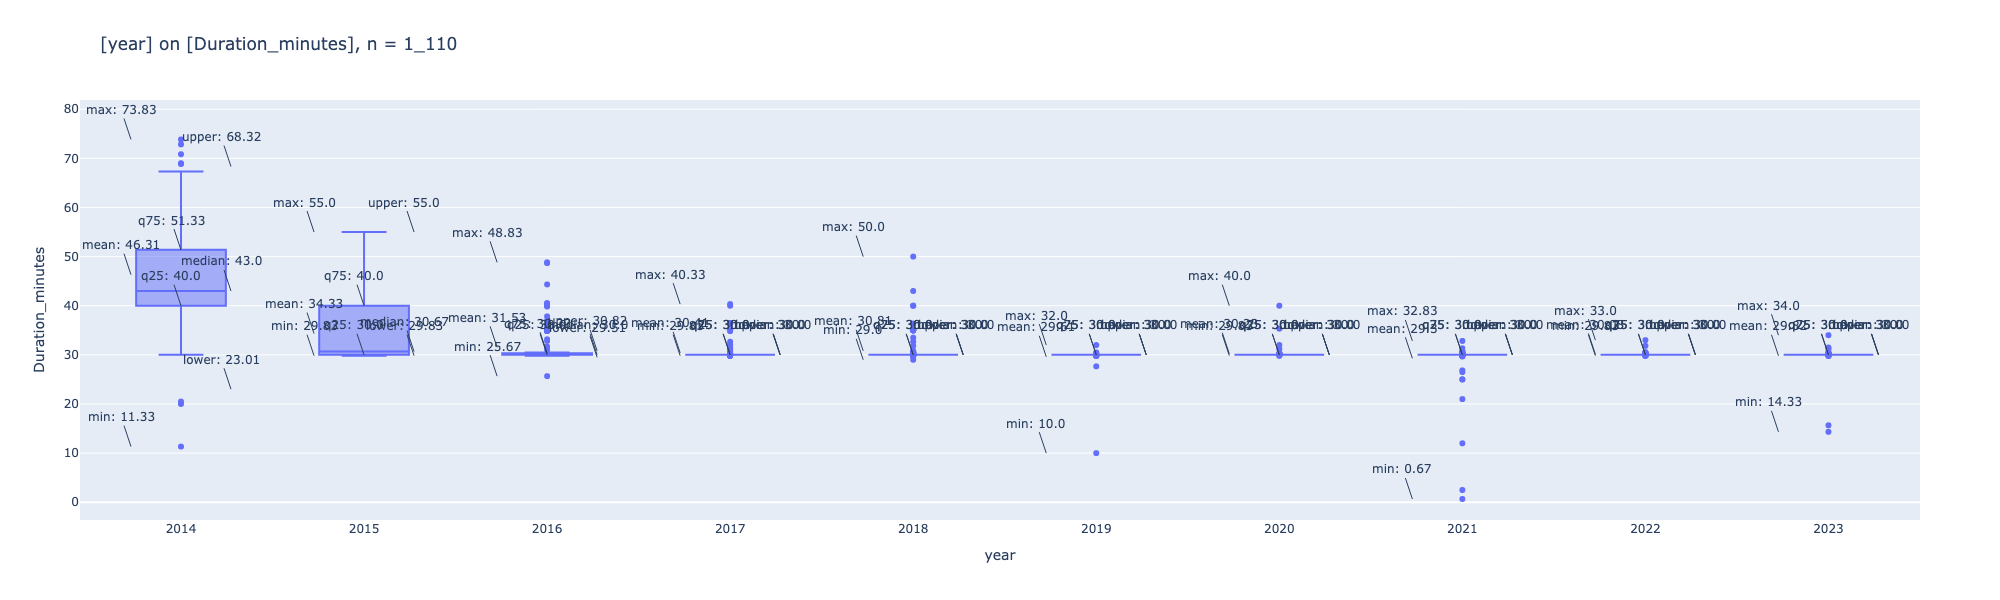

Duration_minutes min: 0.667 | lower: 29.5 | q25: 30.0 | median: 30.0 | mean: 32.353 | q75: 30.333333333333332 | upper: 30.833 | max: 73.833 | std: 6.63 | cv: 0.205 | sum: 35_911.333 | skew: 2.555 | kurto: 10.824


In [15]:
_df1=df[df['year']<'2024'].iloc[:,[2,1]]
_=pls.plot_boxes(_df1,annotations=True, width=2000, png_path=DIR_IMAGES / 'boxplot_duration.png')

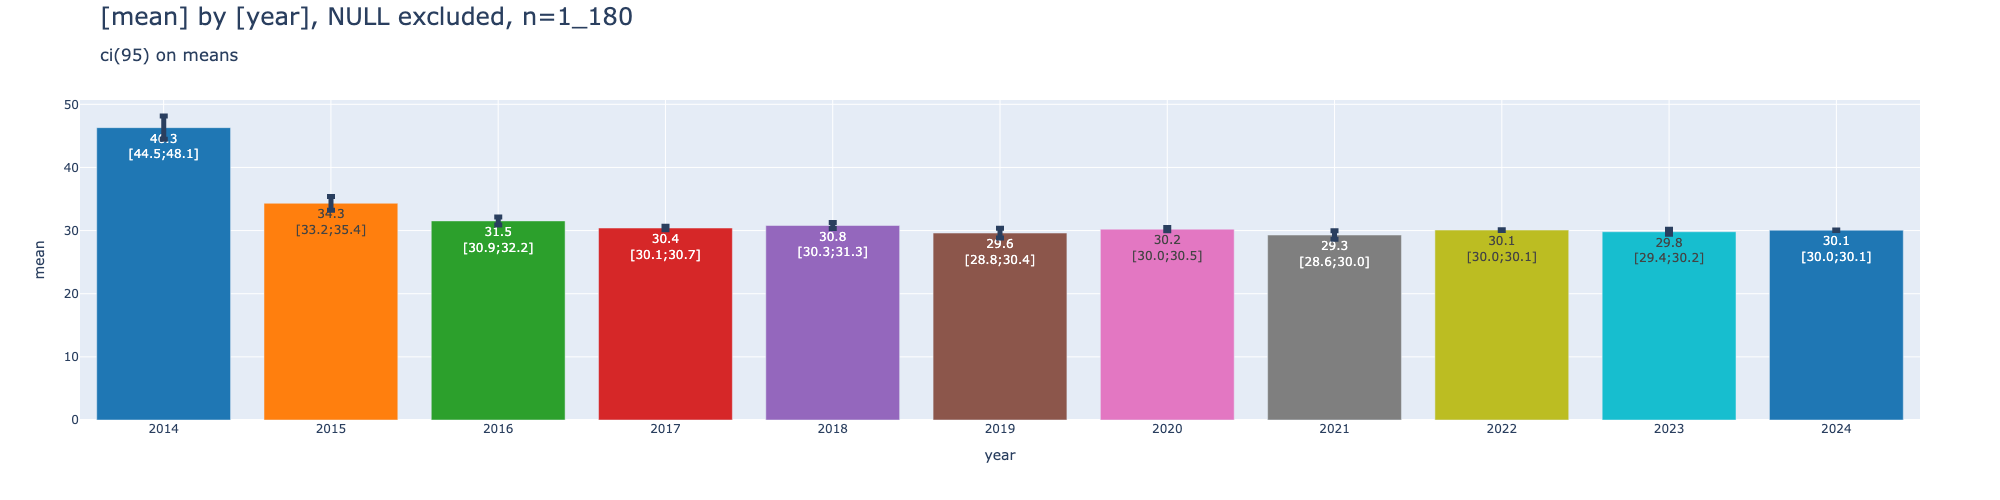

In [16]:
_df=df[["year","Duration_minutes"]]#.astype(float)
_=pls.plot_bars(_df,use_ci=True, width=2000, precision=1, png_path=DIR_IMAGES/'mean_by_year.png')

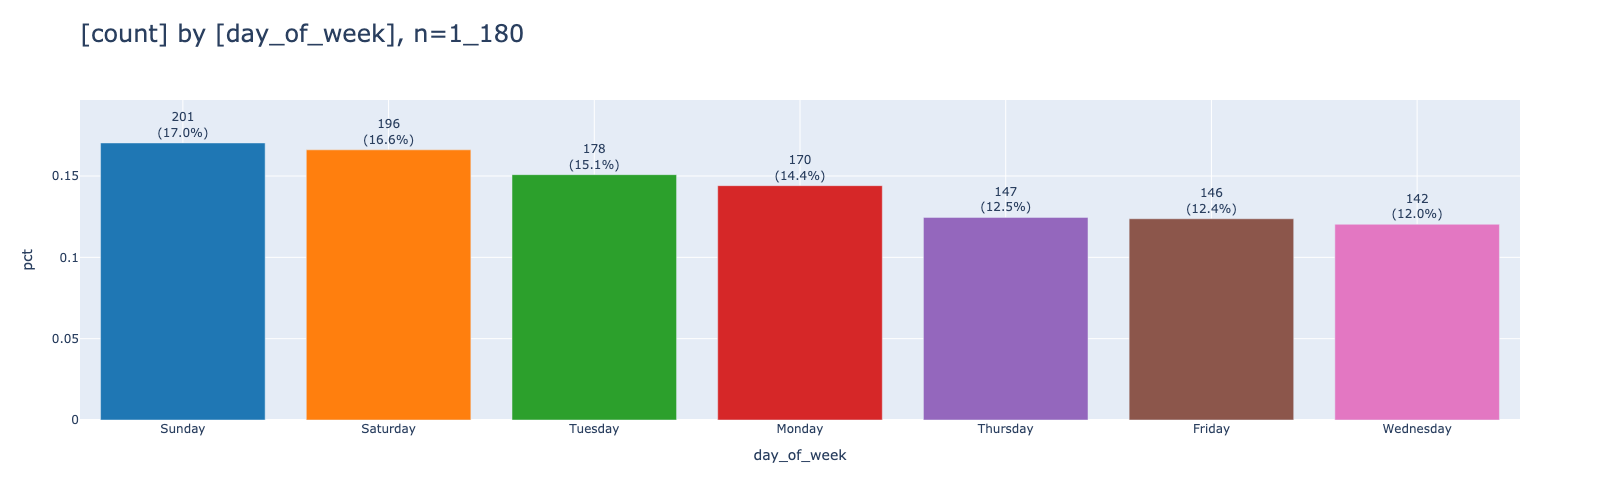

In [17]:
_df=df_training["day_of_week"]
_=pls.plot_bars(_df, sort_values=True, png_path=DIR_IMAGES/'mean_by_day.png')

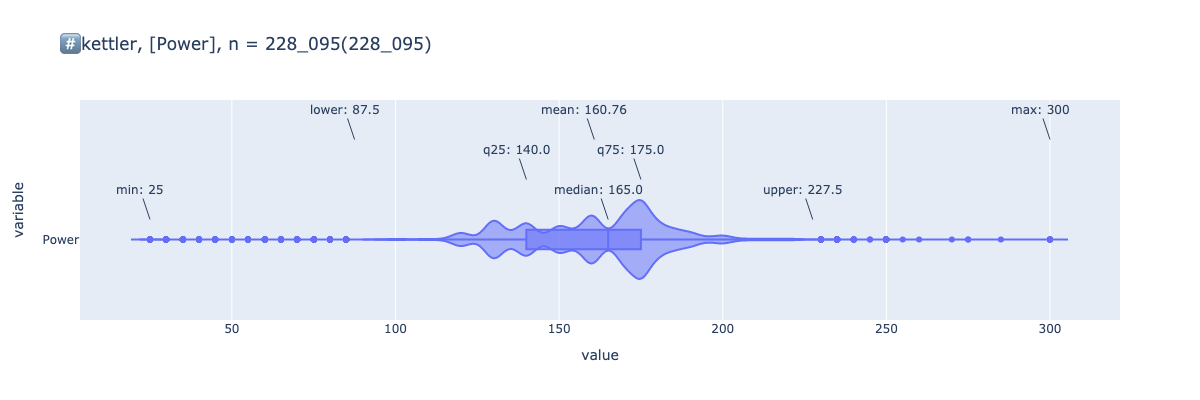

🟠  min: 25 | lower: 87.5 | q25: 140.0 | median: 165.0 | mean: 160.756 | q75: 175.0 | upper: 227.5 | max: 300 | std: 22.972 | cv: 0.143 | sum: 36_667_600 | skew: -0.713 | kurto: 2.506


In [18]:
_=pls.plot_box(df_records['Power'], height=400, violin=True, caption='kettler', png_path=DIR_IMAGES/'boxplot_power.png')

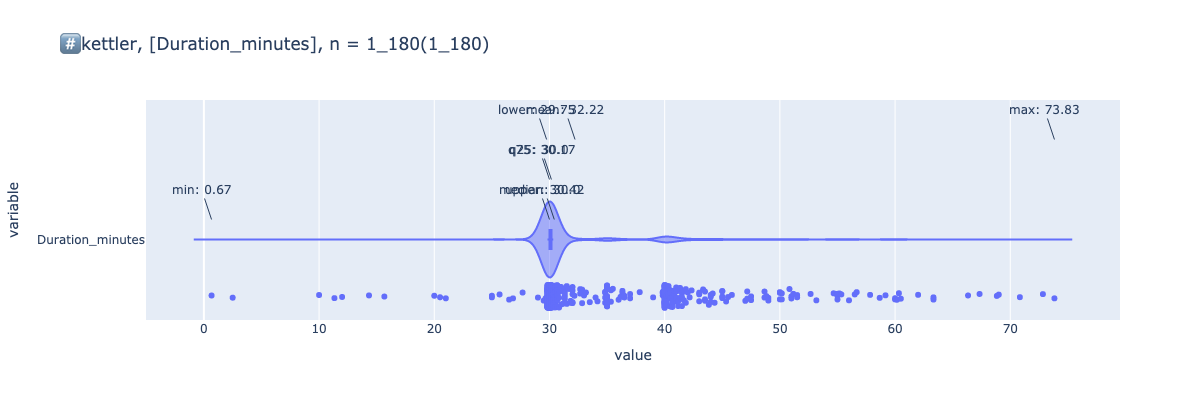

🟠  min: 0.667 | lower: 29.75 | q25: 30.0 | median: 30.0 | mean: 32.217 | q75: 30.166666666666668 | upper: 30.417 | max: 73.833 | std: 6.453 | cv: 0.2 | sum: 38_015.833 | skew: 2.667 | kurto: 11.712


In [19]:
_=pls.plot_box(df_training['Duration_minutes'], height=400, violin=True, caption='kettler', points='all')

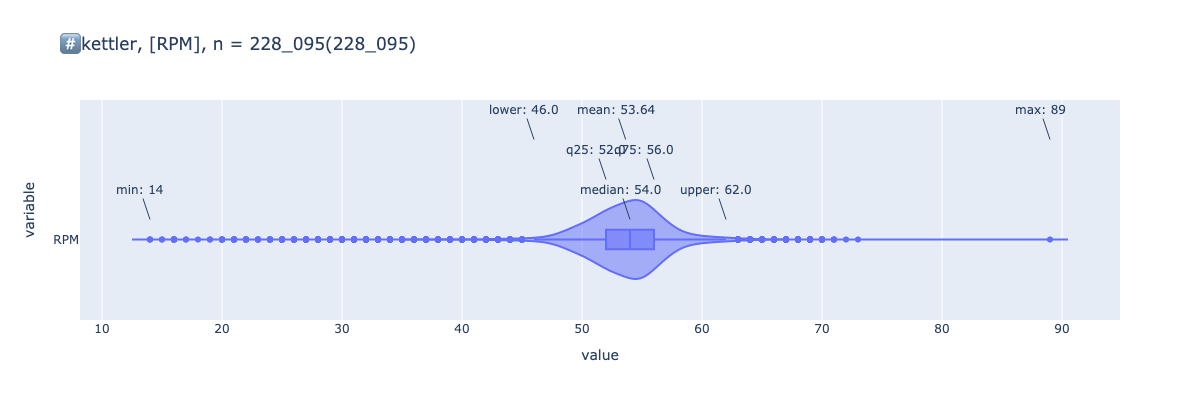

🟠  min: 14 | lower: 46.0 | q25: 52.0 | median: 54.0 | mean: 53.64 | q75: 56.0 | upper: 62.0 | max: 89 | std: 3.513 | cv: 0.065 | sum: 12_234_916 | skew: -0.864 | kurto: 6.636


In [20]:
_=pls.plot_box(df_records['RPM'], height=400, violin=True, caption='kettler')

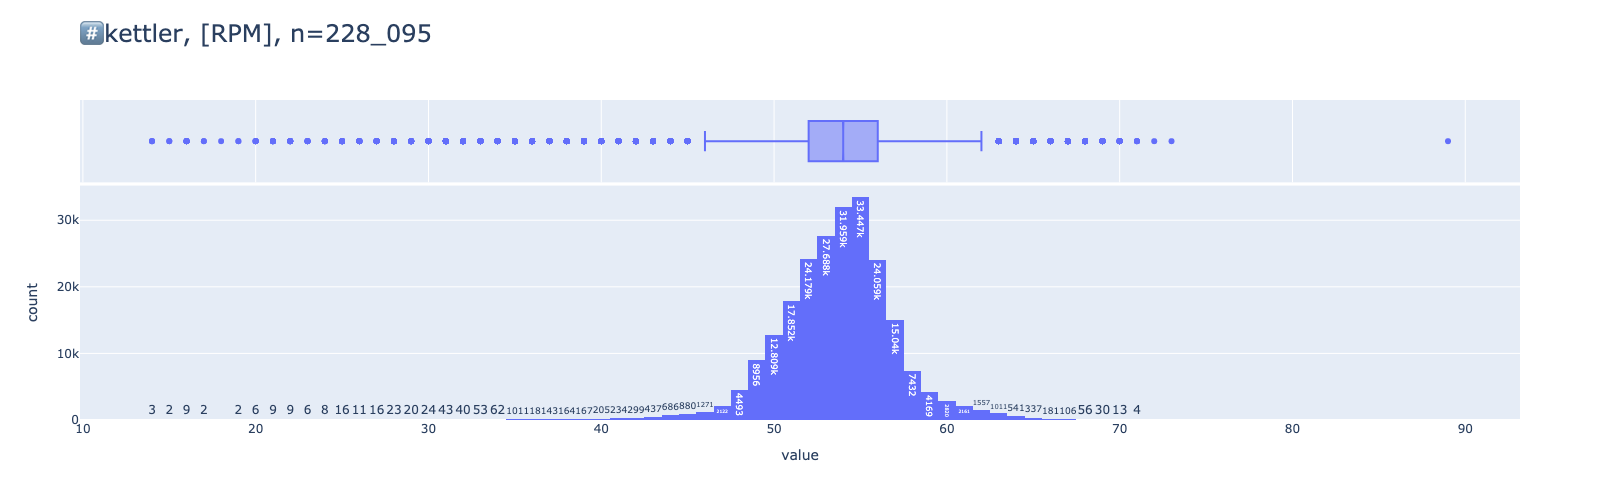

🟠  min: 14 | lower: 46.0 | q25: 52.0 | median: 54.0 | mean: 53.64 | q75: 56.0 | upper: 62.0 | max: 89 | std: 3.513 | cv: 0.065 | sum: 12_234_916 | skew: -0.864 | kurto: 6.636


In [21]:
_=pls.plot_histogram(df_records['RPM'], caption='kettler', precision=0, png_path=DIR_IMAGES/'histogram_rpm.png')
pls.print_summary(df_records['RPM'],) 

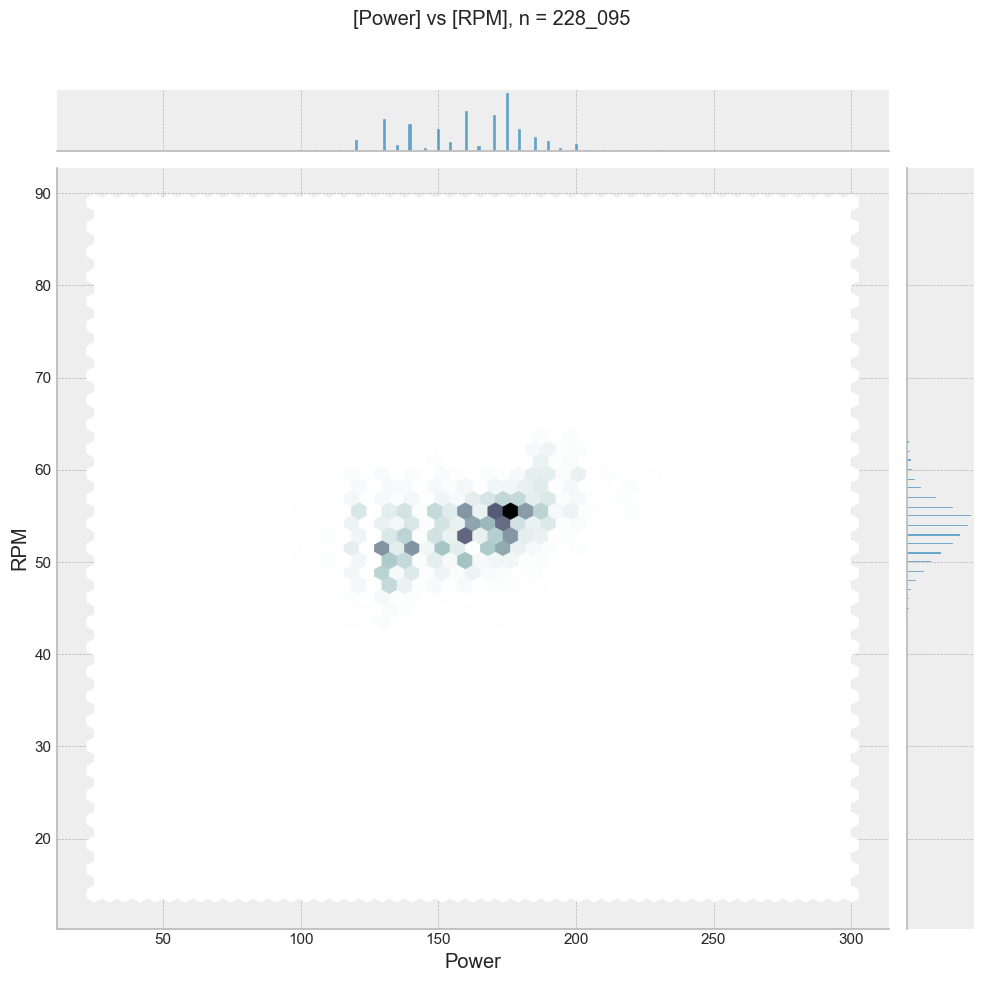

In [22]:
df_records
_df=df_records[['Power','RPM']]
_=pls.plot_joint(_df, kind="hex", size=10, png_path=DIR_IMAGES/'power_rpm.png')


In [23]:
df_training2 = hlp.add_datetime_columns(df_training, "TrainingDateTime")

⏳ Adding datetime columns basing off of: TrainingDateTime


In [24]:
_df= df_records.merge(
    df_training2,
    left_on="TrainingId",
    right_index=True,
)[["YYYY", "MM", "Score_10sec"]]

In [33]:
# Index(['Pulse', 'Power', 'RPM', 'TimePassed_minutes', 'TimePassed_percent',
#        'Score_10sec', 'TrainingId', 'Device', 'Calibration', 'Software',
#        'Date', 'Time', 'RecordIntervall', 'Transmission', 'Energy',
#        'TrainingDateTime', 'FileName', 'CreatedAt', 'Duration_minutes',
#        'Streak_days', 'daytime', 'day_of_week', 'training_date', 'YYYY', 'MM',
#        'Q', 'YYYY-MM', 'YYYYQ', 'YYYY-WW', 'DDD'],
#       dtype='object')

lol = tbl.pivot_df(
    _df,
    precision=0,
    total_axis="x",
    pct_axis="",
    # data_bar_axis="",
    kpi_mode="rag_abs",
    kpi_rag_list=[20, 10],
    swap=True,
    font_size_td=16,
    font_size_th=16,
    png_path=DIR_IMAGES / "pivot_score.png",
    # png_conversion="chrome"
)
lol

YYYY,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
MM,,,,,,,,,,,
1,30 🟩,11 🟨,23 🟩,35 🟩,19 🟨,7 🟥,0 🟥,39 🟩,10 🟥,19 🟨,27 🟩
2,34 🟩,15 🟨,11 🟨,5 🟥,0 🟥,7 🟥,0 🟥,18 🟨,9 🟥,18 🟨,9 🟥
3,30 🟩,17 🟨,16 🟨,11 🟨,1 🟥,19 🟨,0 🟥,9 🟥,19 🟨,25 🟩,17 🟨
4,18 🟨,10 🟨,12 🟨,15 🟨,14 🟨,11 🟨,10 🟨,21 🟩,31 🟩,30 🟩,9 🟥
5,15 🟨,5 🟥,3 🟥,11 🟨,16 🟨,7 🟥,18 🟨,20 🟩,9 🟥,18 🟨,4 🟥
6,14 🟨,11 🟨,7 🟥,15 🟨,39 🟩,0 🟥,9 🟥,0 🟥,0 🟥,10 🟨,1 🟥
7,3 🟥,0 🟥,23 🟩,18 🟨,22 🟩,2 🟥,9 🟥,6 🟥,4 🟥,3 🟥,1 🟥
8,5 🟥,0 🟥,20 🟨,9 🟥,12 🟨,2 🟥,5 🟥,4 🟥,7 🟥,4 🟥,3 🟥
9,21 🟩,15 🟨,6 🟥,12 🟨,22 🟩,4 🟥,16 🟨,13 🟨,11 🟨,6 🟥,5 🟥


In [32]:
# import dataframe_image as dfi

# dfi.export(lol, DIR_IMAGES / "pivot_score.png", max_rows=20, max_cols=10, fontsize=30)